# Problem Statement

Imagine you have a dataset where you have predicted loan Eligibility using any
4 different classification algorithms. 

Now you have to build a model which can
predict loan Eligibility and you need to find the accuracy of the model and 

built-in
docker and use some library to display that in frontend.

## Dataset

Link : https://www.kaggle.com/datasets/ninzaami/loan-predication/download?datasetVersionNumber=1

# Required Libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import skew, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_classif
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import joblib
import os

# Data Ingestion

In [40]:
file_path = "loan_eligibility.csv"

df = pd.read_csv(file_path)

In [41]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# EDA & FE

## Basic info about Dataset

In [42]:
print(f"No of Rows = {df.shape[0]}\nNo of columns = {df.shape[1]}")

No of Rows = 614
No of columns = 13


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


**Observations:**

1. The data set contain 12 Independent features and one target feature i.e. Loan_Status.

2. Out of 12 independent features 7 are categorical and 5 are Numerical.

3. Loan_ID is just a label and unique for each row. It has very little relationship with the loan status. We should drop it.

4. Remaining 6 categorical features need to be encoded into Numerical variables.

## Numerical and Categorical Features

In [44]:
num_col = df.select_dtypes(['int64', 'float64']).columns.to_list()
cat_col = df.select_dtypes('object').columns.to_list()

print(f"Numeric columns : {num_col}\nCategorical columns : {cat_col}")

Numeric columns : ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical columns : ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


## Data Cleaning

### Handle missing values

In [45]:
# Check for missing values and calculate the percentage of missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Columns with missing values and their percentages
columns_with_missing_values = missing_percentage[missing_percentage > 0]

columns_with_missing_values.sort_values(ascending=False).round(2)

Credit_History      8.14
Self_Employed       5.21
LoanAmount          3.58
Dependents          2.44
Loan_Amount_Term    2.28
Gender              2.12
Married             0.49
dtype: float64

**Observations:**

- We can see in the above list that following features have some missing values:

        - Credit_History       8.14

        - Self_Employed        5.21

        - LoanAmount           3.58

        - Dependents           2.44

        - Loan_Amount_Term     2.28

        - Gender               2.12
        
        - Married              0.49

- As the dataset have only 600+ observations, we can't drop all the missing observations. Instead we need to find some satistical approximations for each observation if possible.

- For Categorical features we will fill the missing values with mode of the respective column.

- For Numerical Features we will fill the missing values with mean or median values.

In [46]:
# Handling missing values

# Credit_History: Fill with the mode (most frequent value)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

# Self_Employed: Fill with the mode (most frequent value)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)

# LoanAmount: Fill with the mean
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)

# Dependents: Fill with the mode (most frequent value)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)

# Loan_Amount_Term: Fill with the median
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median(), inplace=True)

# Gender: Fill with the mode (most frequent value)
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)

# Married: Fill with the mode (most frequent value)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)



In [47]:
# Verify if there are no more missing values
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

**Comment:**

Successfully handled all the missing values without removing them.

### Remove duplicates

In [48]:
df.duplicated().sum()

0

**No Duplicated rows found.**

### Deal with outliers

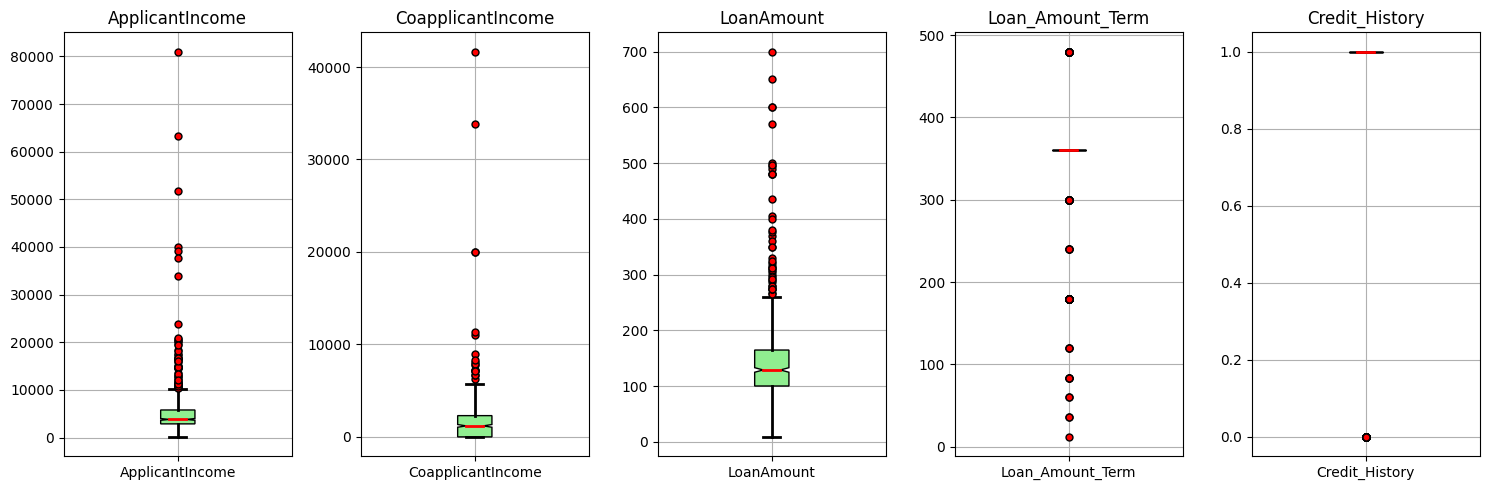

In [49]:
# Create a subplot grid for the boxplots
fig, axes = plt.subplots(nrows=1, ncols=len(num_col), figsize=(15, 5))

# Iterate over the numerical columns and create boxplots in each subplot
for i, column in enumerate(num_col):
    ax = axes[i]  # Select the current subplot
    # Create the boxplot for the current column
    boxplot = df.boxplot(column=column, ax=ax, patch_artist=True, notch=True,
                         whiskerprops=dict(linewidth=2),
                         capprops=dict(linewidth=2),
                         medianprops=dict(linewidth=2, color='red'),
                         boxprops=dict(facecolor='lightgreen', color='black'),
                         flierprops=dict(marker='o', markersize=5, markerfacecolor='red'))
    
    ax.set_title(column)  # Set the title of the subplot
    
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

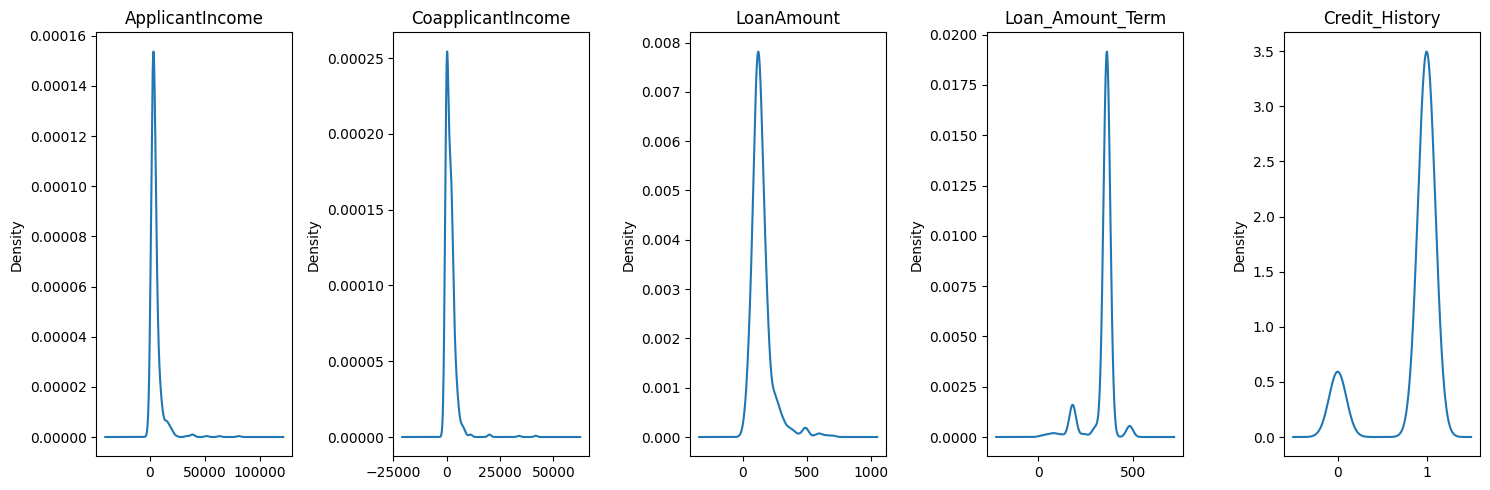

In [50]:
# Create a subplot grid for the kdeplots
fig, axes = plt.subplots(nrows=1, ncols=len(num_col), figsize=(15, 5))

# Iterate over the numerical columns and create kdeplots in each subplot
for i, column in enumerate(num_col):
    ax = axes[i]  # Select the current subplot
    # Create the kdeplot for the current column
    df[column].plot(kind='kde', ax=ax)
    
    ax.set_title(column)  # Set the title of the subplot
    
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

**Observations:**

1. Credit History has binary distribution. So don't need to do anything special to handle the outliers.
2. We can see few negative values in CoapplicantIncome, which is not acceptable. We must convert them to positive

#### Hndleing Outlier using Transformers

1) logarithmic transformation, 

2) square root transformation, 

3) Box-Cox transformation.

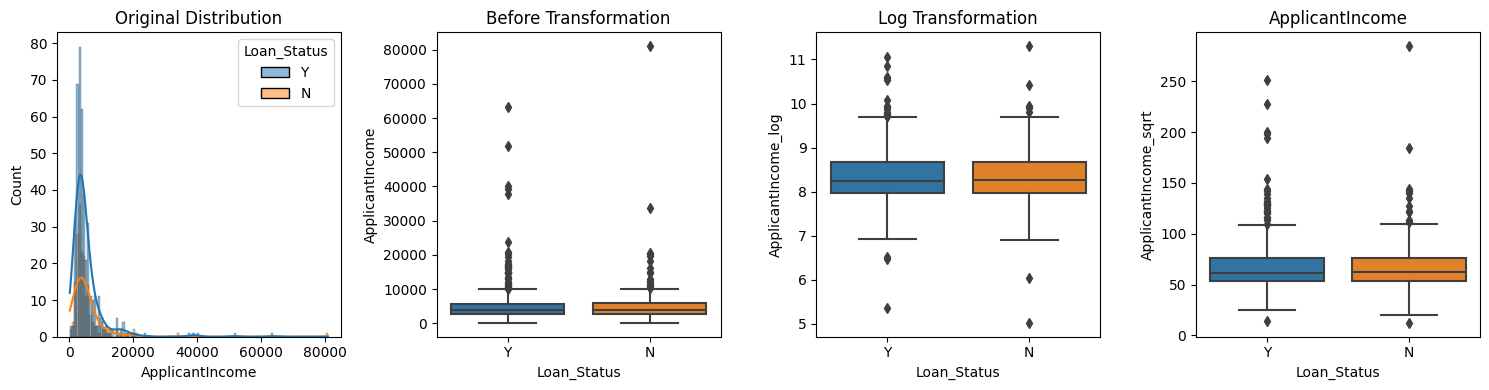

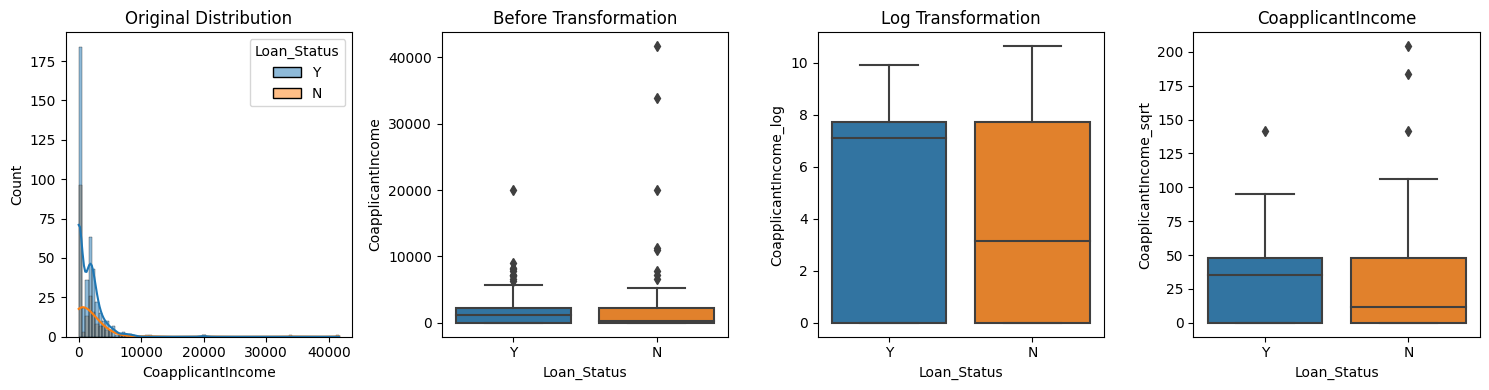

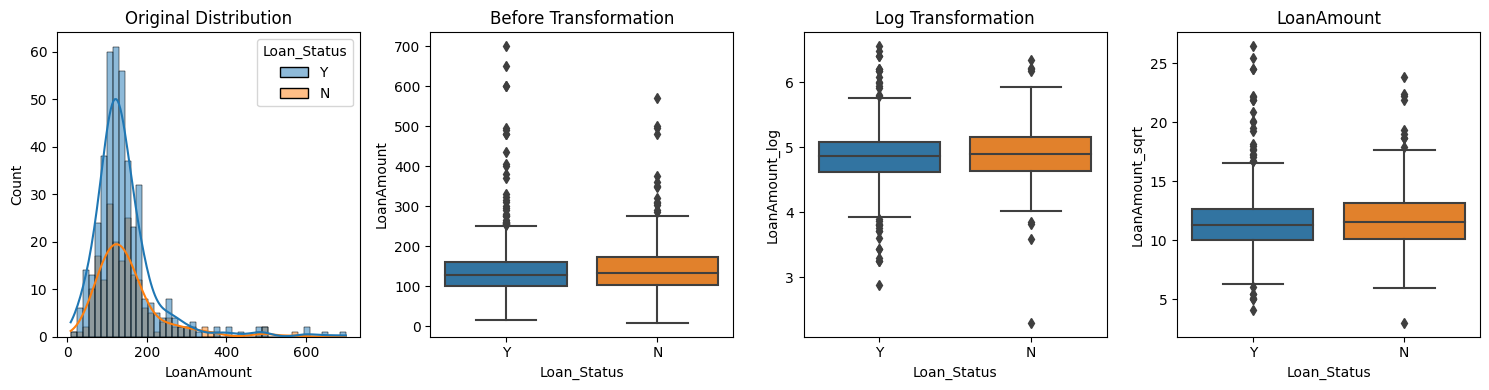

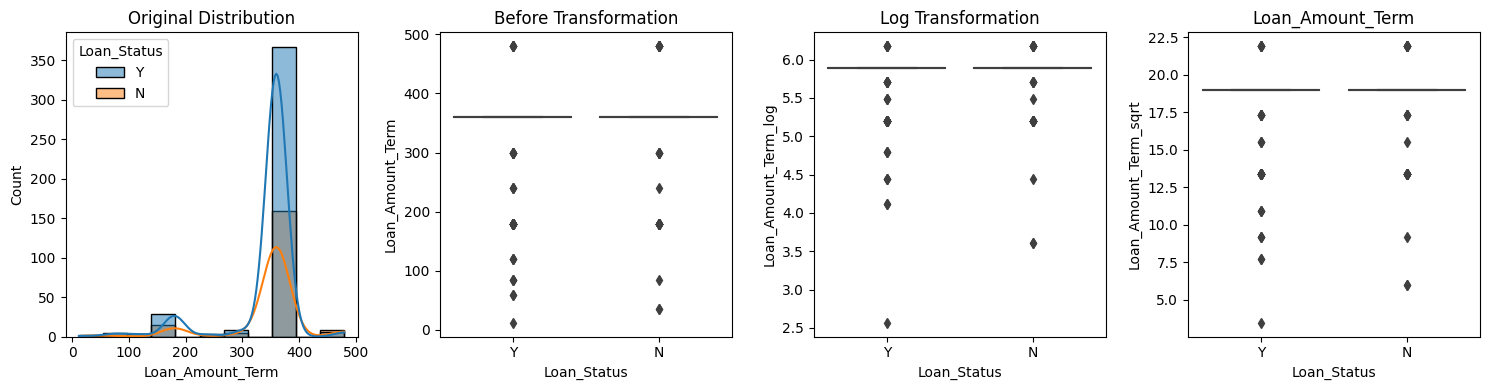

Column: ApplicantIncome
Log Transformation: Mean Difference = 0.0152, Std Difference = 0.0489
Square Root Transformation: Mean Difference = 0.1047, Std Difference = 1.4586

Column: CoapplicantIncome
Log Transformation: Mean Difference = 0.5062, Std Difference = 0.1609
Square Root Transformation: Mean Difference = 0.5496, Std Difference = 6.784

Column: LoanAmount
Log Transformation: Mean Difference = 0.0446, Std Difference = 0.0108
Square Root Transformation: Mean Difference = 0.2711, Std Difference = 0.0397

Column: Loan_Amount_Term
Log Transformation: Mean Difference = 0.0055, Std Difference = 0.0139
Square Root Transformation: Mean Difference = 0.069, Std Difference = 0.1416



In [51]:
# Define the target variable
target_col = 'Loan_Status'

# Create a list of transformation columns to evaluate
transform_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

# Initialize a dictionary to store the evaluation results
transform_results = {}

# Loop through each transformation column
for col in transform_cols:
    # Apply log transformation
    df[col+'_log'] = np.log1p(df[col])
    
    # Apply square root transformation
    df[col+'_sqrt'] = np.sqrt(df[col])
    
    # Plot the distributions and boxplots for each transformation
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    
    # Plot the original distribution
    sns.histplot(data=df, x=col, hue=target_col, kde=True, ax=axes[0])
    axes[0].set_title('Original Distribution')
    
    # Plot the boxplots for each transformation
    sns.boxplot(x=target_col, y=col, data=df, ax=axes[1])
    axes[1].set_title('Before Transformation')
    
    sns.boxplot(x=target_col, y=col+'_log', data=df, ax=axes[2])
    axes[2].set_title('Log Transformation')

    sns.boxplot(x=target_col, y=col+'_sqrt', data=df, ax=axes[3])
    axes[3].set_title('Square Root Transformation')
    
    plt.tight_layout()
    plt.title(col)
    plt.show()
    
    # Calculate statistical measures for each transformation
    log_mean_diff = df.groupby(target_col)[col+'_log'].mean().diff().abs().values[-1]
    sqrt_mean_diff = df.groupby(target_col)[col+'_sqrt'].mean().diff().abs().values[-1]
    log_std_diff = df.groupby(target_col)[col+'_log'].std().diff().abs().values[-1]
    sqrt_std_diff = df.groupby(target_col)[col+'_sqrt'].std().diff().abs().values[-1]
    
    # Store the evaluation results in the dictionary
    transform_results[col] = {
        'Log Transformation': (log_mean_diff, log_std_diff),
        'Square Root Transformation': (sqrt_mean_diff, sqrt_std_diff)
    }

# Print the evaluation results
for col, results in transform_results.items():
    print(f"Column: {col}")
    for transform, (mean_diff, std_diff) in results.items():
        print(f"{transform}: Mean Difference = {mean_diff.round(4)}, Std Difference = {std_diff.round(4)}")
    print()


**Observations:**

By analysing the above plots and transformation results, we can see that the log transformations works best with our dataset.

We must keep the log transformation columns only and remove the original and sqrt transformed columns.

In [52]:
for col in transform_cols:
    df.drop(columns=[col, col+'_sqrt'], inplace=True)

In [53]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Loan_Amount_Term_log
0,LP001002,Male,No,0,Graduate,No,1.0,Urban,Y,8.674197,0.000000,4.993232,5.888878
1,LP001003,Male,Yes,1,Graduate,No,1.0,Rural,N,8.430327,7.319202,4.859812,5.888878
2,LP001005,Male,Yes,0,Graduate,Yes,1.0,Urban,Y,8.006701,0.000000,4.204693,5.888878
3,LP001006,Male,Yes,0,Not Graduate,No,1.0,Urban,Y,7.857094,7.765993,4.795791,5.888878
4,LP001008,Male,No,0,Graduate,No,1.0,Urban,Y,8.699681,0.000000,4.955827,5.888878


### Resolve inconsistencies

In [54]:
###

## Encoding Categorical features

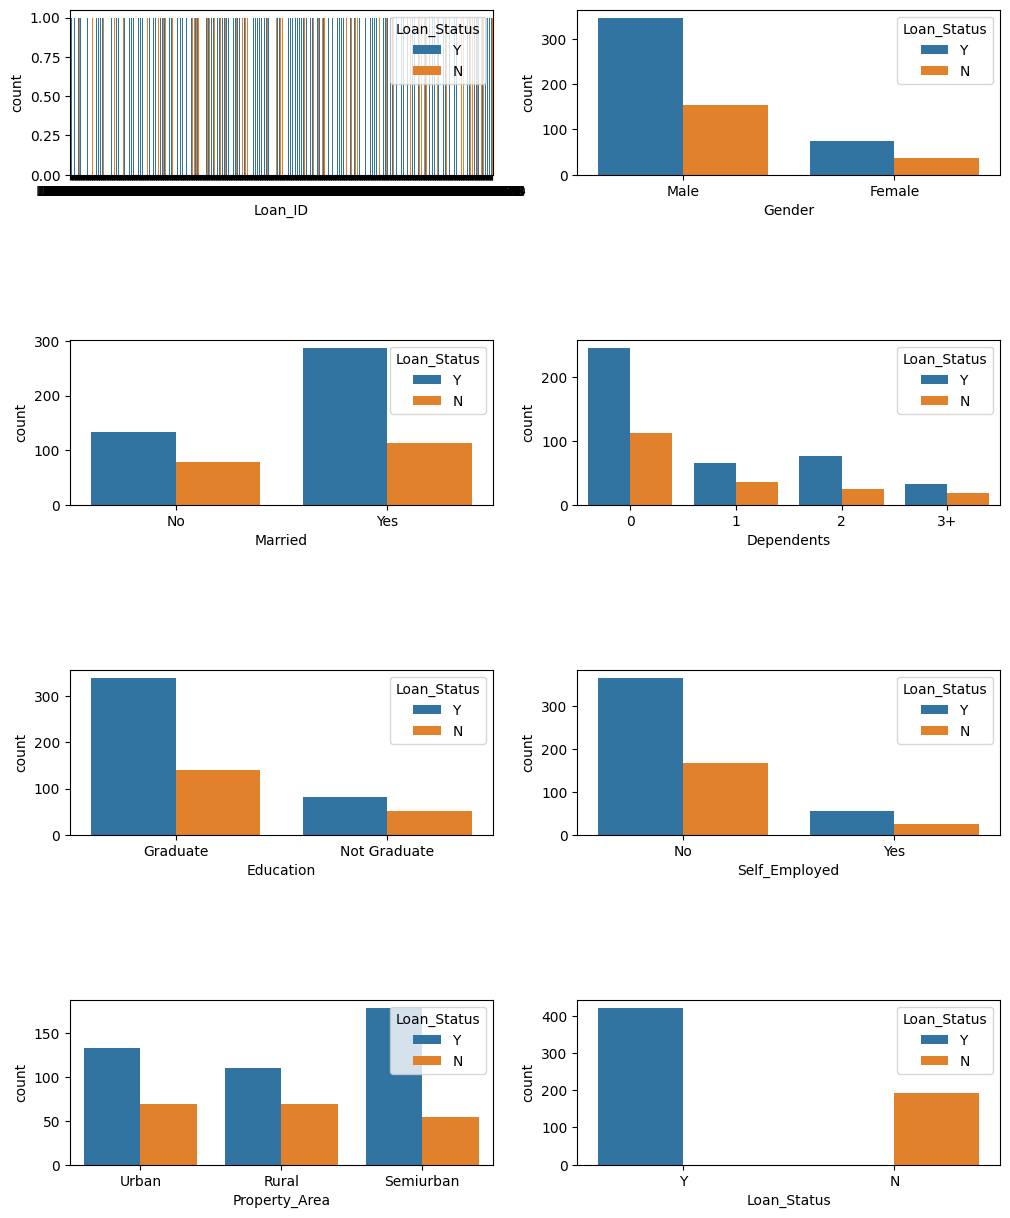

In [55]:
fig,axes = plt.subplots(4,2,figsize=(12,15))
for idx,cat_col in enumerate(cat_col):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=df,hue='Loan_Status',ax=axes[row,col])


plt.subplots_adjust(hspace=1)

<Axes: xlabel='Loan_ID', ylabel='Loan_Status'>

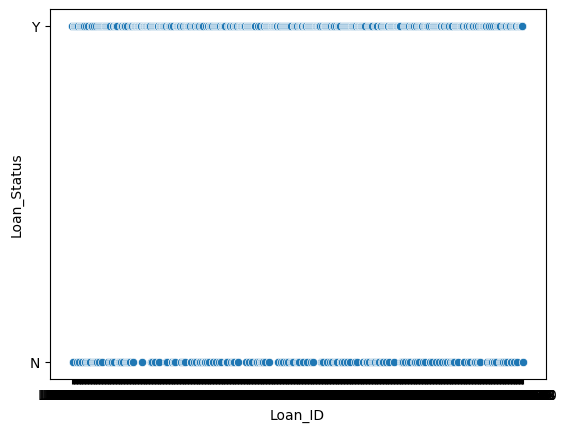

In [56]:
sns.scatterplot(df, x='Loan_ID', y='Loan_Status')

**Observations:**

- **Loan_ID**: As there is no usefull relation between the Loan_ID and Loan_Status, we must drop Loan_ID column.
- **Gender**: There are more Men than Women (approx. 3x)
- **Martial Status**: 2/3rd of the population in the dataset is Marred; Married applicants are more likely to be granted loans.
- **Dependents**: Majority of the population have zero dependents and are also likely to accepted for loan.
- **Education**: About 5/6th of the population is Graduate and graduates have higher propotion of loan approval
- **Employment**: 5/6th of population is not self employed.
- **Property Area**: More applicants from Semi-urban and also likely to be granted loans.
- **Loan Amount Term**: Majority of the loans taken are for 360 Months (30 years).
- **Loan Approval Status**: About 2/3rd of applicants have been granted loan.

In [57]:
df.drop(columns=['Loan_ID'], inplace=True)

In [58]:
cat_col = df.select_dtypes('object').columns.to_list()

In [59]:
cat_col

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [60]:
for col in cat_col:
    print(f"Column : {col}\nUnique Values : {df[col].unique()}")

Column : Gender
Unique Values : ['Male' 'Female']
Column : Married
Unique Values : ['No' 'Yes']
Column : Dependents
Unique Values : ['0' '1' '2' '3+']
Column : Education
Unique Values : ['Graduate' 'Not Graduate']
Column : Self_Employed
Unique Values : ['No' 'Yes']
Column : Property_Area
Unique Values : ['Urban' 'Rural' 'Semiurban']
Column : Loan_Status
Unique Values : ['Y' 'N']


#### Label Encoding using map function


In [61]:
# Column : Gender || Unique Values : ['Male' 'Female']
df["Gender"] = df["Gender"].map({'Male':1, 'Female':0})

# Column : Married || Unique Values : ['No' 'Yes']
df["Married"] = df["Married"].map({'Yes':1, 'No':0})

# Column : Dependents || Unique Values : ['0' '1' '2' '3+']
df['Dependents'] = df["Dependents"].map({'0':0, '1':1, '2':2, '3+':3})

# Column : Education || Unique Values : ['Graduate' 'Not Graduate']
df["Education"] = df["Education"].map({'Graduate':1, 'Not Graduate':0})

# Column : Self_Employed || Unique Values : ['No' 'Yes']
df['Self_Employed'] = df["Self_Employed"].map({'Yes':1, 'No':0})

# Column : Property_Area || Unique Values : ['Urban' 'Rural' 'Semiurban']
df['Property_Area'] = df["Property_Area"].map({'Urban':3, 'Semiurban':2, 'Rural':1})

# Column : Loan_Status || Unique Values : ['Y' 'N']
df['Loan_Status'] = df["Loan_Status"].map({'Y':1, 'N':0})


In [62]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Loan_Amount_Term_log
0,1,0,0,1,0,1.0,3,1,8.674197,0.000000,4.993232,5.888878
1,1,1,1,1,0,1.0,1,0,8.430327,7.319202,4.859812,5.888878
2,1,1,0,1,1,1.0,3,1,8.006701,0.000000,4.204693,5.888878
3,1,1,0,0,0,1.0,3,1,7.857094,7.765993,4.795791,5.888878
4,1,0,0,1,0,1.0,3,1,8.699681,0.000000,4.955827,5.888878


In [63]:
# Final check of the encoding
for col in cat_col:
    print(f"Column : {col} | Data Type : {df[col].dtype}\nUnique Values : {df[col].unique()}\n")

Column : Gender | Data Type : int64
Unique Values : [1 0]

Column : Married | Data Type : int64
Unique Values : [0 1]

Column : Dependents | Data Type : int64
Unique Values : [0 1 2 3]

Column : Education | Data Type : int64
Unique Values : [1 0]

Column : Self_Employed | Data Type : int64
Unique Values : [0 1]

Column : Property_Area | Data Type : int64
Unique Values : [3 1 2]

Column : Loan_Status | Data Type : int64
Unique Values : [1 0]



## Final checking for missing values

In [64]:
df.isna().sum()

Gender                   0
Married                  0
Dependents               0
Education                0
Self_Employed            0
Credit_History           0
Property_Area            0
Loan_Status              0
ApplicantIncome_log      0
CoapplicantIncome_log    0
LoanAmount_log           0
Loan_Amount_Term_log     0
dtype: int64

# Feature Seperation

In [65]:
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']


In [66]:
X.shape

(614, 11)

# Feature Selection

#### Corellation Matrix Heatmap

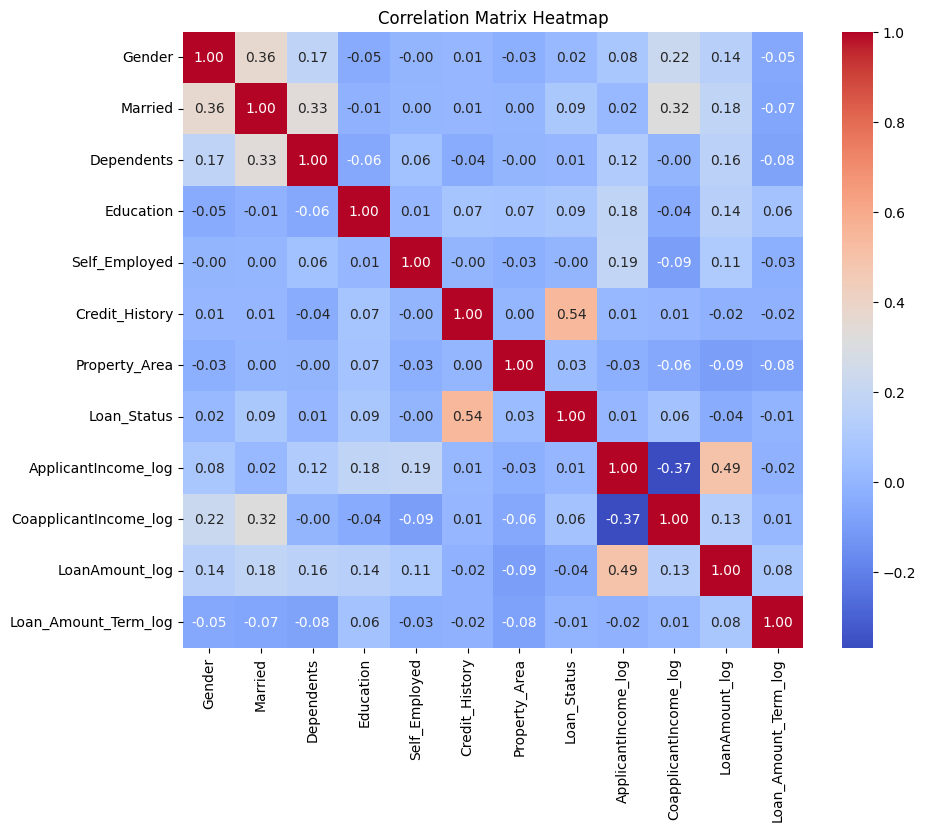

In [67]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", mask=False)

# Set plot title and labels
plt.title("Correlation Matrix Heatmap")
# plt.xlabel("Features")
# plt.ylabel("Features")

# Show the plot
plt.show()

#### Multicolinearity

In [68]:
# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Features'] = df.columns
vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
# Print the VIF values
print(vif)

                 Features         VIF
8     ApplicantIncome_log  240.482763
10         LoanAmount_log  161.427714
11   Loan_Amount_Term_log  143.287393
5          Credit_History    9.718076
6           Property_Area    7.560438
0                  Gender    6.611508
3               Education    4.854493
7             Loan_Status    4.634725
1                 Married    4.040495
9   CoapplicantIncome_log    3.320269
2              Dependents    1.817274
4           Self_Employed    1.199094


**Observations:**

        Features             |     VIF

8  |   ApplicantIncome_log   |   240.482763

10 |        LoanAmount_log   |   161.427714

11 |  Loan_Amount_Term_log   |    143.287393

- If the threshold VIF score is set as 10, then 3 features has considerable high VIF score, indicating a strong correlation with other features in the dataset. 

- To reduce multicollinearity and potential overfitting, we must consider dropping one or more of these features.

- But all of them are important parameter while deciding whether the Loan will get approved or not.

#### p-Value

In [69]:
# Add a constant column to the features for the intercept term
X = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Get the p-values for each feature
p_values = result.pvalues

Optimization terminated successfully.
         Current function value: 0.466182
         Iterations 6


In [70]:
p_values.apply(lambda x: round(x,4)).sort_values()

Credit_History           0.0000
LoanAmount_log           0.0256
Married                  0.0460
CoapplicantIncome_log    0.0602
ApplicantIncome_log      0.1170
const                    0.1269
Education                0.1542
Property_Area            0.4662
Gender                   0.4846
Dependents               0.5618
Loan_Amount_Term_log     0.7543
Self_Employed            0.9504
dtype: float64

**Comment:**

In general, a common threshold for significance is a p-value of 0.05 or lower. 

Based on the p-value chart we provided, the features with p-values greater than 0.05 are typically considered less statistically significant. 

However, the decision of whether to drop a feature should not be based solely on p-values, but should also consider domain knowledge and the overall context of our problem.

Based on the provided p-value chart, the features with higher p-values (greater than 0.05) are:

- Property_Area
- Gender
- Dependents
- Loan_Amount_Term_log
- Self_Employed

### **Conclusion:**

Few features are there in the dataset that can cause Multicolinearity, which can affect the interpretability of the coefficients in a regression model and lead to overfitting. 

On the other hand, few features are Statistically insignificant on the basis of p-values (>0.05).

But according to domain knowledge all these features play an important role while approving a Loan.

So it will not be an appropriate decision to drop them.

Instead we can choose modeling techniques that are more robust to multicollinearity, such as regularized regression (e.g., Ridge or Lasso regression), which can help mitigate the impact of multicollinearity while still incorporating the important features.

# Train-Test Split

In [72]:
X.drop(columns=['const'], inplace=True)

In [73]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the train and test sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (491, 11) (491,)
Test set shape: (123, 11) (123,)


# Model Initiation

In [74]:
# Initialize the models
lasso_model = Lasso()
ridge_model = Ridge()
logistic_model = LogisticRegression()
random_forest_model = RandomForestClassifier()
decision_tree_model = DecisionTreeClassifier()

# Model Training

In [75]:
# Fit the models
lasso_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
logistic_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier()

# Prediction

In [76]:
# Make predictions on Train Data
lasso_train_preds = lasso_model.predict(X_train)
ridge_train_preds = ridge_model.predict(X_train)
logistic_train_preds = logistic_model.predict(X_train)
random_forest_train_preds = random_forest_model.predict(X_train)
decision_tree_train_preds = decision_tree_model.predict(X_train)

In [77]:
# Make predictions on Test Data
lasso_preds = lasso_model.predict(X_test)
ridge_preds = ridge_model.predict(X_test)
logistic_preds = logistic_model.predict(X_test)
random_forest_preds = random_forest_model.predict(X_test)
decision_tree_preds = decision_tree_model.predict(X_test)

In [78]:
threshold = 0.5

# Apply threshold to predicted probabilities on train set
lasso_train_preds_binary = (lasso_train_preds > threshold).astype(int)
ridge_train_preds_binary = (ridge_train_preds > threshold).astype(int)
logistic_train_preds_binary = (logistic_train_preds > threshold).astype(int)
random_forest_train_preds_binary = (random_forest_train_preds > threshold).astype(int)
decision_tree_train_preds_binary = (decision_tree_train_preds > threshold).astype(int)

# Apply threshold to predicted probabilities on test set
lasso_preds_binary = (lasso_preds > threshold).astype(int)
ridge_preds_binary = (ridge_preds > threshold).astype(int)
logistic_preds_binary = (logistic_preds > threshold).astype(int)
random_forest_preds_binary = (random_forest_preds > threshold).astype(int)
decision_tree_preds_binary = (decision_tree_preds > threshold).astype(int)

# Model Performance 

### Accuracy

In [79]:
# Evaluate model performance
lasso_acc = accuracy_score(y_test, lasso_preds_binary).round(4)*100
ridge_acc = accuracy_score(y_test, ridge_preds_binary).round(4)*100
logistic_acc = accuracy_score(y_test, logistic_preds_binary).round(4)*100
random_forest_acc = accuracy_score(y_test, random_forest_preds_binary).round(4)*100
decision_tree_acc = accuracy_score(y_test, decision_tree_preds_binary).round(4)*100

In [80]:
# Print accuracy scores
print("Lasso Accuracy:", lasso_acc)
print("Ridge Accuracy:", ridge_acc)
print("Logistic Regression Accuracy:", logistic_acc)
print("Random Forest Accuracy:", random_forest_acc)
print("Decision Tree Accuracy:", decision_tree_acc)

Lasso Accuracy: 65.03999999999999
Ridge Accuracy: 78.86
Logistic Regression Accuracy: 78.86
Random Forest Accuracy: 78.05
Decision Tree Accuracy: 69.92


### Cross-validation

In [81]:
# Perform cross-validation for each model
lasso_cv_scores = cross_val_score(lasso_model, X, y, cv=5)
ridge_cv_scores = cross_val_score(ridge_model, X, y, cv=5)
logistic_cv_scores = cross_val_score(logistic_model, X, y, cv=5)
random_forest_cv_scores = cross_val_score(random_forest_model, X, y, cv=5)
decision_tree_cv_scores = cross_val_score(decision_tree_model, X, y, cv=5)

# Print cross-validation scores
print("Lasso Cross-Validation Scores:", lasso_cv_scores)
print("Ridge Cross-Validation Scores:", ridge_cv_scores)
print("Logistic Regression Cross-Validation Scores:", logistic_cv_scores)
print("Random Forest Cross-Validation Scores:", random_forest_cv_scores)
print("Decision Tree Cross-Validation Scores:", decision_tree_cv_scores)

/home/tinku/anaconda3/envs/assesment/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/tinku/anaconda3/envs/assesment/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Lasso Cross-Validation Scores: [-0.00111338 -0.00013789 -0.00302774 -0.00010358 -0.00034775]
Ridge Cross-Validation Scores: [0.30200654 0.16122944 0.25862643 0.3959064  0.29159106]
Logistic Regression Cross-Validation Scores: [0.81300813 0.7804878  0.7804878  0.85365854 0.81967213]
Random Forest Cross-Validation Scores: [0.78861789 0.75609756 0.77235772 0.82926829 0.80327869]
Decision Tree Cross-Validation Scores: [0.68292683 0.61788618 0.72357724 0.74796748 0.74590164]


### Classification Report

In [82]:
# Generate classification reports
lasso_report = classification_report(y_test, lasso_preds_binary)
ridge_report = classification_report(y_test, ridge_preds_binary)
logistic_report = classification_report(y_test, logistic_preds_binary)
random_forest_report = classification_report(y_test, random_forest_preds_binary)
decision_tree_report = classification_report(y_test, decision_tree_preds_binary)

# Print classification reports
print("Lasso Classification Report:")
print(lasso_report)
print("Ridge Classification Report:")
print(ridge_report)
print("Logistic Regression Classification Report:")
print(logistic_report)
print("Random Forest Classification Report:")
print(random_forest_report)
print("Decision Tree Classification Report:")
print(decision_tree_report)

Lasso Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.65      1.00      0.79        80

    accuracy                           0.65       123
   macro avg       0.33      0.50      0.39       123
weighted avg       0.42      0.65      0.51       123

Ridge Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85    

/home/tinku/anaconda3/envs/assesment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tinku/anaconda3/envs/assesment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tinku/anaconda3/envs/assesment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

### Confusion Matrix

In [83]:
# Confusion matrix for Lasso model
lasso_cm = confusion_matrix(y_test, lasso_preds_binary)
print("Confusion Matrix - Lasso:")
print(lasso_cm, end='\n')

# Confusion matrix for Ridge model
ridge_cm = confusion_matrix(y_test, ridge_preds_binary)
print("Confusion Matrix - Ridge:")
print(ridge_cm, end='\n')

# Confusion matrix for Logistic Regression model
logistic_cm = confusion_matrix(y_test, logistic_preds_binary)
print("Confusion Matrix - Logistic Regression:")
print(logistic_cm, end='\n')

# Confusion matrix for Decision Tree Classifier model
dt_cm = confusion_matrix(y_test, decision_tree_preds_binary)
print("Confusion Matrix - Decision Tree Classifier:")
print(dt_cm, end='\n')

# Confusion matrix for Random Forest Classifier model
rf_cm = confusion_matrix(y_test, random_forest_preds_binary)
print("Confusion Matrix - Random Forest Classifier:")
print(rf_cm, end='\n')

Confusion Matrix - Lasso:
[[ 0 43]
 [ 0 80]]
Confusion Matrix - Ridge:
[[18 25]
 [ 1 79]]
Confusion Matrix - Logistic Regression:
[[18 25]
 [ 1 79]]
Confusion Matrix - Decision Tree Classifier:
[[23 20]
 [17 63]]
Confusion Matrix - Random Forest Classifier:
[[18 25]
 [ 2 78]]


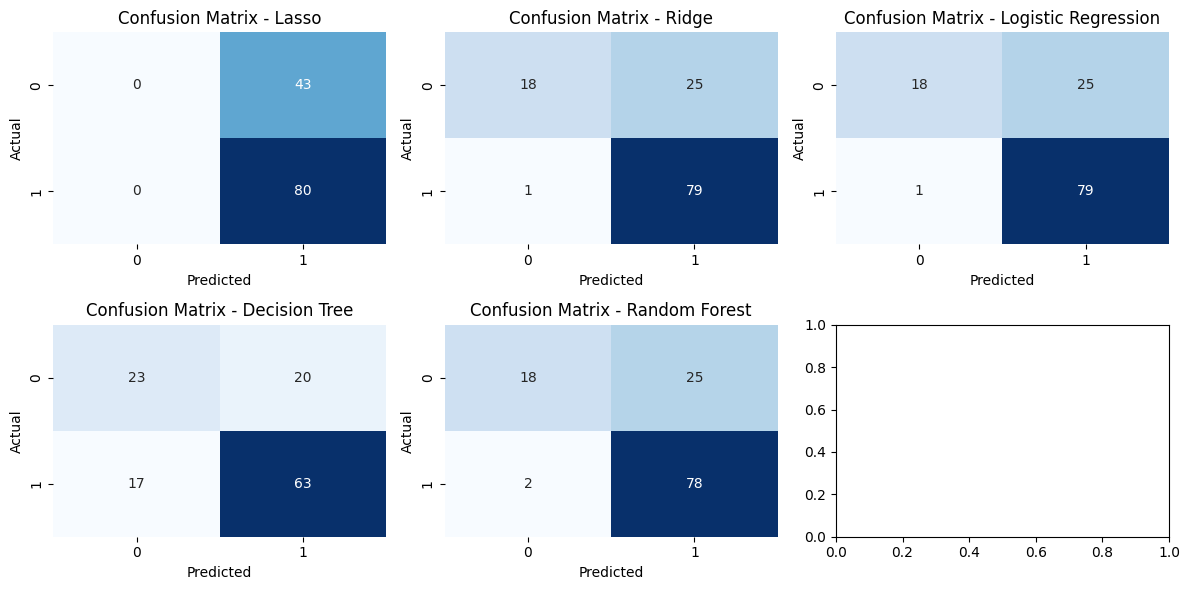

In [84]:
# Create a list of confusion matrices and their corresponding labels
cm_list = [(lasso_cm, "Lasso"), (ridge_cm, "Ridge"), (logistic_cm, "Logistic Regression"), (dt_cm, "Decision Tree"), (rf_cm, "Random Forest")]

# Plotting confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for i, (cm, label) in enumerate(cm_list):
    ax = axes[i//3, i%3]
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=ax)
    ax.set_title("Confusion Matrix - {}".format(label))
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

### Graphical comparision of Model's Performances

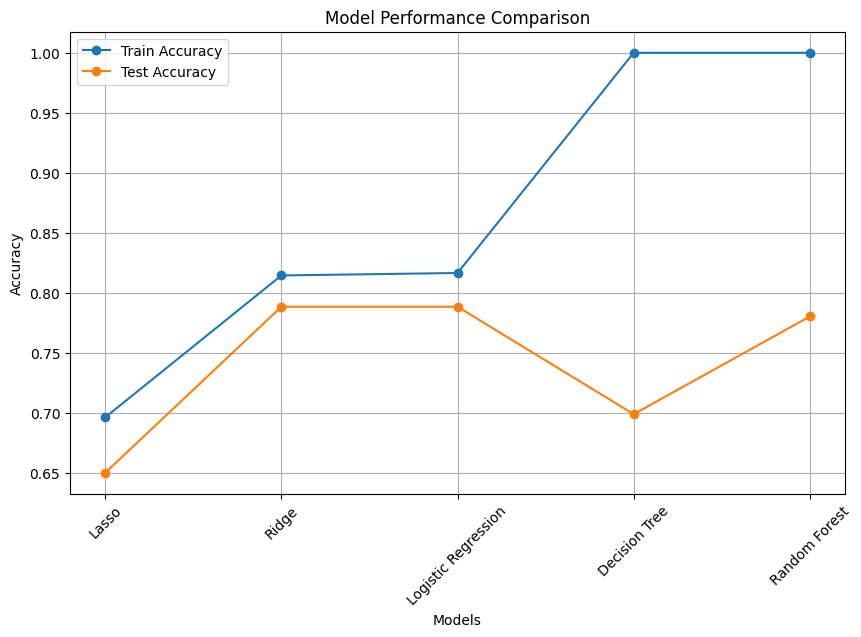

In [85]:
# Calculate train accuracy for each model
lasso_train_acc = accuracy_score(y_train, lasso_train_preds_binary)
ridge_train_acc = accuracy_score(y_train, ridge_train_preds_binary)
logistic_train_acc = accuracy_score(y_train, logistic_train_preds_binary)
dt_train_acc = accuracy_score(y_train, decision_tree_train_preds_binary)
rf_train_acc = accuracy_score(y_train, random_forest_train_preds_binary)

# Calculate test accuracy for each model
lasso_test_acc = accuracy_score(y_test, lasso_preds_binary)
ridge_test_acc = accuracy_score(y_test, ridge_preds_binary)
logistic_test_acc = accuracy_score(y_test, logistic_preds_binary)
dt_test_acc = accuracy_score(y_test, decision_tree_preds_binary)
rf_test_acc = accuracy_score(y_test, random_forest_preds_binary)

# Create lists of train and test accuracies for each model
train_acc = [lasso_train_acc, ridge_train_acc, logistic_train_acc, dt_train_acc, rf_train_acc]
test_acc = [lasso_test_acc, ridge_test_acc, logistic_test_acc, dt_test_acc, rf_test_acc]
models = ['Lasso', 'Ridge', 'Logistic Regression', 'Decision Tree', 'Random Forest']

# Plotting the accuracy comparison
plt.figure(figsize=(10, 6))
plt.plot(models, train_acc, marker='o', label='Train Accuracy')
plt.plot(models, test_acc, marker='o', label='Test Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


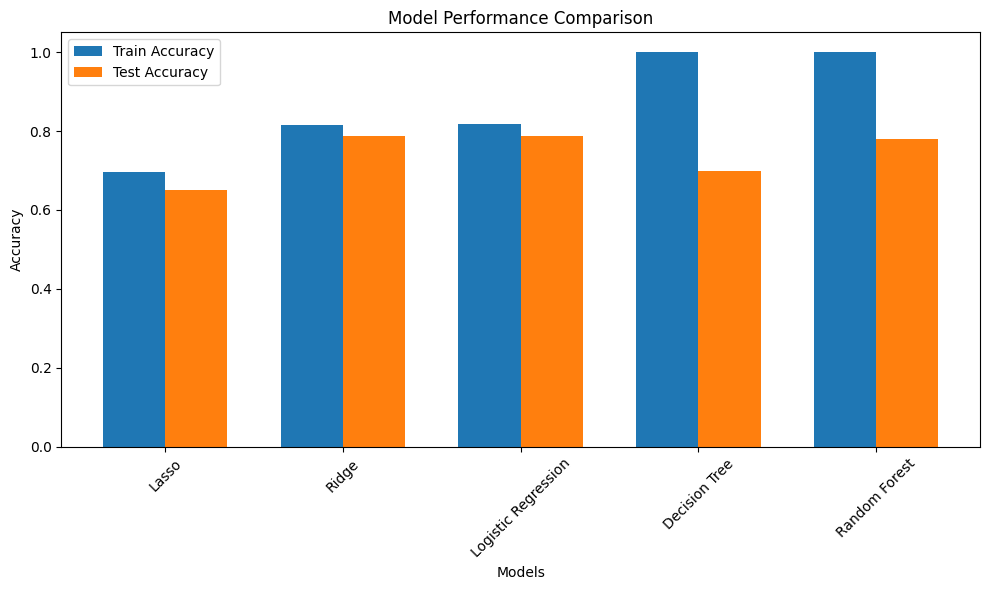

In [86]:
x = np.arange(len(models))
width = 0.35

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the train accuracies
ax.bar(x - width/2, train_acc, width, label='Train Accuracy')

# Plot the test accuracies
ax.bar(x + width/2, test_acc, width, label='Test Accuracy')

# Set labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Model Selection 

With the help of all the analysis on model performance, we have two best performing models with nearly same accuracy:

- Ridge classifier

- Logistic regression classifier

# Save Model

In [87]:
# Create a directory to save the models if it doesn't exist
if not os.path.exists("Models"):
    os.makedirs("Models")

# Save the Ridge model
ridge_model_path = os.path.join("Models", "ridge_model.pkl")
joblib.dump(ridge_model, ridge_model_path)

# Save the Logistic Regression model
logistic_model_path = os.path.join("Models", "logistic_model.pkl")
joblib.dump(logistic_model, logistic_model_path)

['Models/logistic_model.pkl']

# Predict using saved model

In [88]:
# Load the saved models
ridge_model = joblib.load('Models/ridge_model.pkl')
logistic_model = joblib.load('Models/logistic_model.pkl')

In [89]:
ridge_model.feature_names_in_

array(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Credit_History', 'Property_Area', 'ApplicantIncome_log',
       'CoapplicantIncome_log', 'LoanAmount_log', 'Loan_Amount_Term_log'],
      dtype=object)

In [90]:
input_data = [[1,1,3,1,1,1,3,np.log1p(25400), np.log1p(5000), np.log1p(50000), np.log1p(72)]]

# Use the models to make predictions
ridge_prediction = ridge_model.predict(input_data)
logistic_prediction = logistic_model.predict(input_data)

/home/tinku/anaconda3/envs/assesment/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/tinku/anaconda3/envs/assesment/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [92]:
print(ridge_prediction, logistic_prediction)

[0.32538638] [0]
